## Machine Learning OMAT5200M 
## Summative Assessment 2

# _A Study of SVM and CNN for Typed Character Recognition_


#### Student: 201804870

#### Email: od23kp@leeds.ac.uk


## Abstract

This project aims to recognize typed letters surrounded by ellipses in images. To achieve this, we first preprocessed the dataset by applying Principal Component Analysis (PCA) for dimensionality reduction, effectively retaining key features while minimizing computational complexity. The Support Vector Machine (SVM) was optimized through a grid search, revealing that the linear kernel demonstrated superior generalization capabilities compared to the Convolutional Neural Network (CNN).

Major findings indicate that the SVM outperformed the CNN in terms of accuracy, precision, recall, and F1-scores, establishing its robustness for this classification task.

This study underscores the effectiveness of SVMs, particularly with linear kernels, for character recognition applications, highlighting their potential in practical scenarios.

# 1. Introduction/Project Plan

## The Data

The motivation behind this project is to enhance the efficiency of navigating spool drawings by introducing interactive highlighting between the picklist of labels and their corresponding locations within the drawing. This functionality aims to streamline the process of identifying and locating specific labels in densely packed drawings. 

Refer to Appendix A for Background and Example Spool Drawing

## 2. Aims, objectives and plan

### a) Aims and objectives

#### Aim

The primary aim of this project is to develop a machine learning-based tool to automate the recognition of typed letters inside ellipses with high accuracy. 

#### Objectives

1. **Feature Extraction**: Preprocess the spool drawing images by identifying and isolating the key visual features of letters enclosed in ellipses to facilitate effective classification by machine learning models.

2. **Model Training**: Develop and train two machine learning models: a Support Vector Machine (SVM) and a Convolutional Neural Network (CNN). The SVM will classify the images based on extracted features, while the CNN will process raw pixel data. Both models are trained to classify each image into one of 26 letter classes (A-Z).

3. **Evaluation**: Compare the performance of the SVM and CNN models using accuracy, precision, recall, and F1-score metrics to identify the best-performing model.

###  b) Project Plan 

<img src="project_plan.png" alt="Project Plan Mermaid Diagram" style="width: 50%; height: auto;">


## 3. Understanding the case study

###  Case study analysis  
1. **Class Imbalance**

2. **Image Resizing**

3. **Pixel Value Range**

4. **Color Space Standardization**

Please refer to Appendix B for Specific Findings and Solutions

## 4. Dataset description
The dataset contains 100 pre-augmented images of each letter from the English alphabet, each enclosed within an ellipse, for a total of 2600 images. The letter data contains a mix of serif and sans-serif fonts.

For loading data into Jupyter, please refer to Appendix C.

The data is further preprocessed for both algorithms by loading the paths and labels into the coding environment, performing one-hot-encoding, and splitting the data into training, testing, and validation sets. 

### Installing and loading packages

In [1]:
%%capture
pip install -r requirements.txt

In [2]:
%%capture
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import zipfile

from IPython.display import display, HTML
from PIL import Image as PILImage
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow.keras.applications import MobileNetV3Small  # You can choose any pre-trained model
from tensorflow.keras.saving import load_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


2024-10-28 04:08:29.381961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 04:08:29.403284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 04:08:29.409635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 04:08:29.425135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 04:08:30.636409: W tensorflow/comp

In [3]:
def load_images_from_directory(base_dir):
    '''
    Load image paths and their corresponding labels from a specified directory.
    
    Params:
    base_dir (str): The path to the base directory containing subfolders of images.

    Returns:
    tuple: A tuple containing:
        - List[str]: A list of file paths to the images.
        - List[str]: A list of labels corresponding to each image.
    '''
    image_paths = []
    labels = []
    
    # Iterate through each subfolder (which represents a label)
    for label in os.listdir(base_dir):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):  
            for img_file in os.listdir(label_dir):
                if img_file.endswith(('.png')): 
                    image_paths.append(os.path.join(label_dir, img_file))
                    labels.append(label)
    
    return image_paths, labels

In [4]:
# Set the base directory for image data and load image paths and labels.
base_directory = '/home/jovyan/work/spool_drawing_data'
image_paths, labels = load_images_from_directory(base_directory)

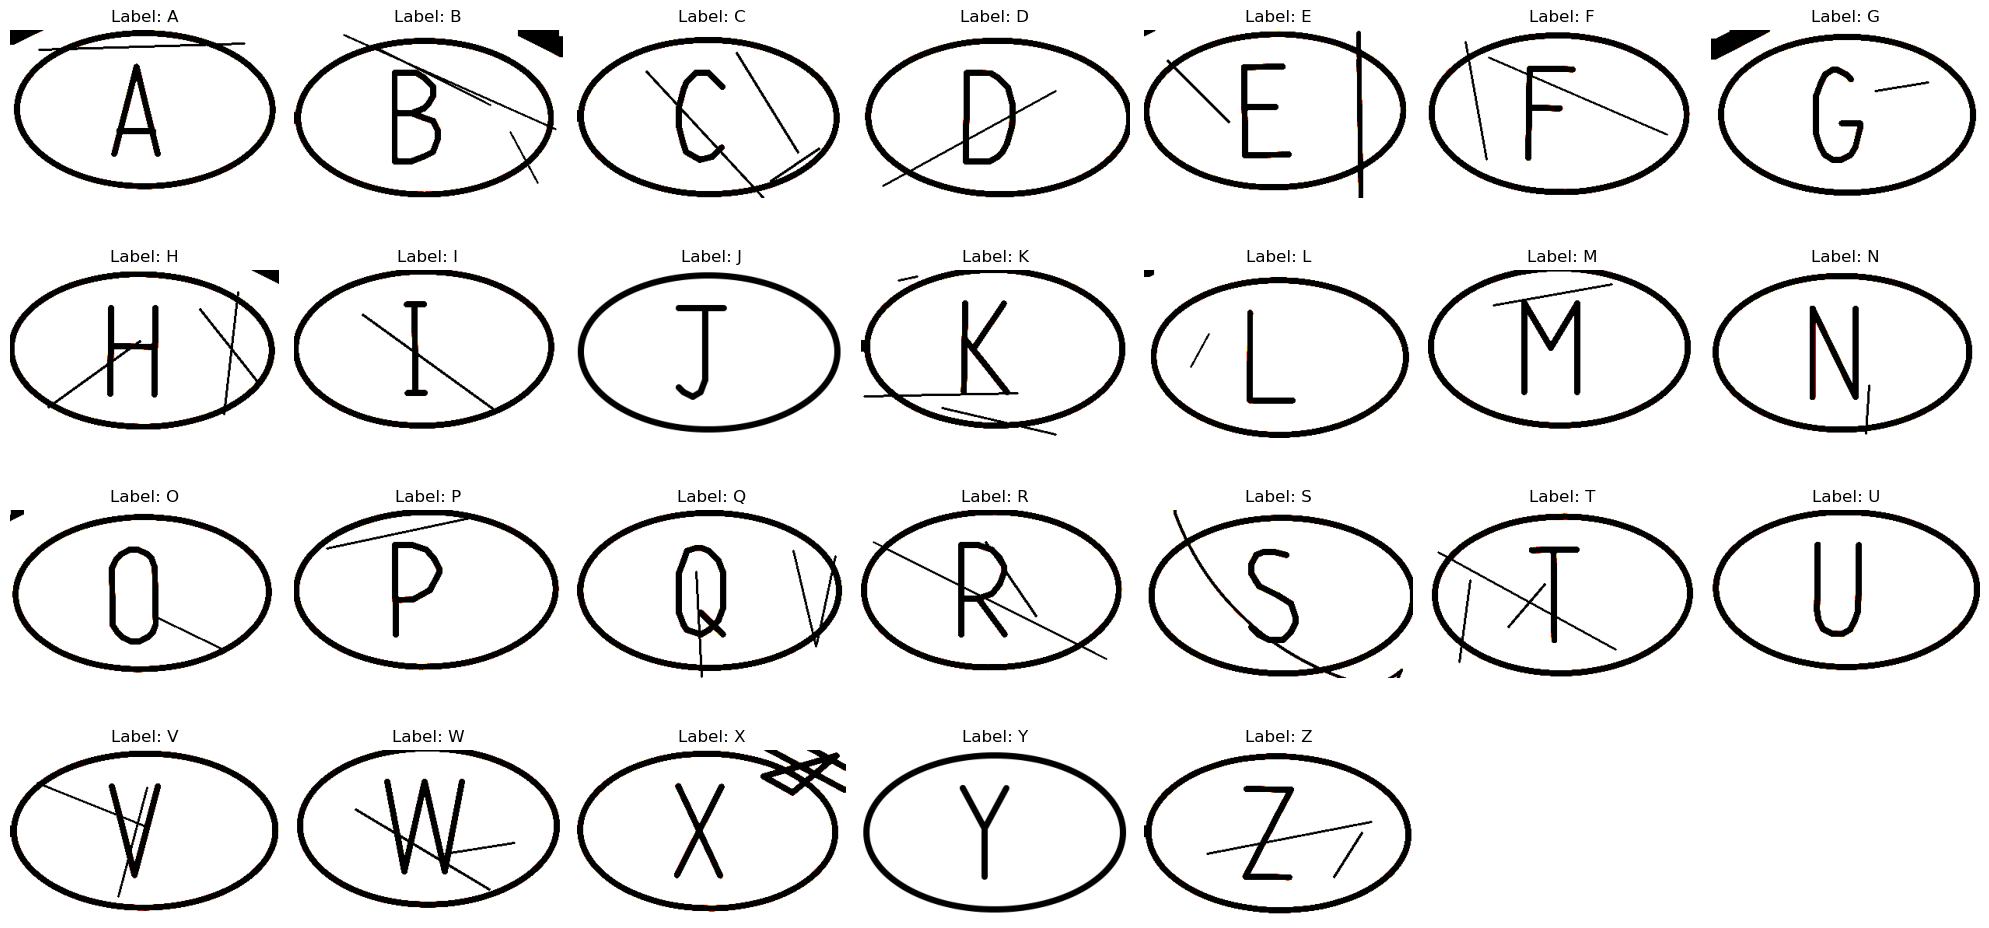

In [5]:
def display_one_per_class(image_paths, labels):
    '''
    Display a single image per class with a matching label above
    
    Params:
    image_paths: List[str]: A list of file paths to the images.
    labels: List[str]: A list of labels corresponding to each image.
    
    '''
    # Create a dictionary to hold one image path per class
    unique_images = {}

    for img_path, label in zip(image_paths, labels):
        if label not in unique_images:
            unique_images[label] = img_path # Add the first image of each class to the dictionary
        if len(unique_images) == 26:
            break
    
    # Sort the dictionary alphabetically
    sorted_unique_images = dict(sorted(unique_images.items()))
    
    plt.figure(figsize=(20, 10))
    
    # Display images
    for i, (label, img_path) in enumerate(sorted_unique_images.items()):
        img = PILImage.open(img_path)
        plt.subplot(4, 7, i + 1)  # 4 rows, 7 columns to fit 26 images
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_one_per_class(image_paths, labels)

In [6]:
# Convert labels to categorical format (one-hot encoding)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [7]:
# Split data into training (50%) and testing (50%)
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels_categorical, 
                                                                test_size=0.50, random_state=9, stratify=labels)

# Further split into validation (20%) and testing (30%) for CNN training
X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_test_paths, y_test, 
    test_size=0.6, random_state=9, stratify=y_test  # 40% of the 50% gives us 20% for validation
)

In [8]:
# Used for training metrics
def format_training_time(seconds):
    """
    Convert training time from seconds to a string format of minutes and seconds.
    
    Params:
        seconds (float): Training time in seconds.
        
    Returns:
        str: Formatted string showing the training time in minutes and seconds.
    """
    if seconds >= 60:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{minutes} minutes and {seconds:.2f} seconds"
    else:
        return f"{seconds:.2f} seconds"


## 5. Technique - Support Vector Machine

### a) Discuss your motivation for choosing the technique and provide a schematic figure of the process


Please refer to Appendix D for motivation and schematic figure of support vector machine. 


### b) Setting hyper parameters (rationale)


In [9]:
# Prepare data for SVM - needs to be one dimensional
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

In [10]:
def images_to_arrays(image_paths, target_size=None):
    '''
    Convert a list of image paths to a NumPy array, with optional resizing.
    
    Params:
        image_paths (List[str]): A list of file paths to the images.
        target_size (tuple): Optional size to resize the images (width, height).
    
    Returns: 
        X (numpy.ndarray): 2D array where each row is a flattened image array.
    '''
    image_arrays = []
    for path in image_paths:
        # Skip directories
        if os.path.isdir(path):
            continue
            
        img = PILImage.open(path)
        img = img.convert('RGB')
        
        # Resize the image if target size is provided
        if target_size:
            img = img.resize(target_size)
        
        img_array = np.array(img) / 255  # Normalizing pixel values
        img_flattened = img_array.flatten()
        image_arrays.append(img_flattened)
    
    X = np.vstack(image_arrays)
    return X


# Convert image paths to arrays
X_train_2d = images_to_arrays(X_train_paths, target_size=(64, 64))
X_test_2d = images_to_arrays(X_test_paths, target_size=(64, 64))

In [11]:
# Timing for computational efficiency
### *Cell takes ~30 minutes to run on my device 
initial_start_time_svm = time.time()

# Default SVM model C=1.0, kernel='rbf', degree=3, gamma='scale'
# To start, using Dafault model for hyperparameters
# Initialize model
svm_model = SVC(verbose=True)
    
# Train the SVM model
svm_model.fit(X_train_2d, y_train_1d)
print("Model Fitting Complete")

svm_initial_training_time = time.time() - initial_start_time_svm
print(f"SVM Training Time: {format_training_time(svm_initial_training_time)}")

[LibSVM]*.*
optimization finished, #iter = 122
obj = -12.564974, rho = 0.118013
nSV = 52, nBSV = 4
*.*
optimization finished, #iter = 145
obj = -14.078282, rho = 0.107964
nSV = 60, nBSV = 7
*.*
optimization finished, #iter = 153
obj = -12.020242, rho = 0.305212
nSV = 64, nBSV = 2
*.*
optimization finished, #iter = 145
obj = -11.901756, rho = 0.090424
nSV = 57, nBSV = 3
.*
optimization finished, #iter = 151
obj = -14.682812, rho = 0.189968
nSV = 62, nBSV = 6
*.*
optimization finished, #iter = 126
obj = -13.565862, rho = 0.244478
nSV = 60, nBSV = 7
*.*
optimization finished, #iter = 141
obj = -12.879703, rho = 0.248607
nSV = 58, nBSV = 4
*.*
optimization finished, #iter = 129
obj = -15.410545, rho = -0.033865
nSV = 57, nBSV = 8
*.*
optimization finished, #iter = 142
obj = -16.679877, rho = 0.155992
nSV = 63, nBSV = 9
*.*
optimization finished, #iter = 131
obj = -15.385842, rho = -0.003575
nSV = 54, nBSV = 8
*.*
optimization finished, #iter = 156
obj = -14.695677, rho = 0.216184
nSV = 64,

In [12]:
print(f"The initial performance of the SVM indicates {format_training_time(svm_initial_training_time)} for a single fitting run. PCA will be implemented so a GridSearch can be ran to tune the hyperparameters")

The initial performance of the SVM indicates 29.0 minutes and 20.05 seconds for a single fitting run. PCA will be implemented so a GridSearch can be ran to tune the hyperparameters


In [13]:
def perform_PCA(X_train, X_test, n_components):
    '''
    Performs Principal Component Analysis (PCA) to reduce dimensionality of data.
    
    Params:
        X_train (array): Training data with features to be scaled and reduced.
        X_test (array): Testing data with features to be scaled and reduced.
        n_components (int): Target number of principal component to retain.
        
    Returns:
        pca (PCA): Trained PCA model containing the components and explained variance information.
        X_train_pca (np.ndarray): Transformed training data in the reduced PCA feature space.
        X_test_pca (np.ndarray): Transformed testing data in the reduced PCA feature space.
    '''

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return pca, X_train_pca, X_test_pca

In [14]:
pca, X_train_pca, X_test_pca = perform_PCA(X_train_2d, X_test_2d, 500)

In [15]:
# Percentage of variance explained by 500 principal components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance.max())

0.9346213363403925


In [16]:
print(f'''
The initial choice of retaining 500 principal components was made as an estimate. However, upon further evaluation, 
it was found that these 500 components capture over 90%, specifically {cumulative_variance.max()} of the total variance in the dataset. 
Additional experimentation with different numbers of components confirmed that 500 provided a balanced trade-off 
between preserving variance and improving computational efficiency for the model.
''')


The initial choice of retaining 500 principal components was made as an estimate. However, upon further evaluation, 
it was found that these 500 components capture over 90%, specifically 0.9346213363403925 of the total variance in the dataset. 
Additional experimentation with different numbers of components confirmed that 500 provided a balanced trade-off 
between preserving variance and improving computational efficiency for the model.



### c) Optimising hyper parameters


To optimize hyper parameters, a grid search has been implemented. Cross-validation it utilized to locate the combination with the highest cross-validation score. The default GridSearchCV score of accuracy is used.

In [17]:
### *Grid search takes ~10 mins to run on my device.

def svm_grid_search(model, X_train, y_train):
    '''
    Performs a grid search with cross-validation to identify the best hyperparameters for an SVM model.
    
    Params:
        model (SVC): An instance of the SVM model to be tuned.
        X_train (np.ndarray): The training data
        y_train (np.ndarray): The target labels for the training data.
    
    Returns:
        grid_search.best_params_ (dict): A dictionary of the best hyperparameters found by the grid search.
    '''
    # Define the parameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 10], #not used for linear kernel
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'degree': [2, 3]  # Only used for polynomial kernel
    }

    # Set up the grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

    # Fit the model
    grid_search.fit(X_train_pca, y_train_1d)

    return grid_search.best_params_
    
# Define the model
svc = SVC()

# Perform grid search
best_params = svm_grid_search(svc, X_train_pca, y_train_1d)

print("Best parameters found:", best_params)

Best parameters found: {'C': 0.01, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}


In [18]:
# Defaulting first to the kernel, 'linear', only uses C as an additional hyperparameter, so 0.01 and 'linear will be extracted for training.
# Extract best parameters and train SVM model
C = best_params["C"]
kernel_type = best_params["kernel"]

# Timing for computational efficiency
start_time_svm = time.time()

svm_model = SVC(C=C, kernel=kernel_type)
    
# Train the SVM model
svm_model.fit(X_train_pca, y_train_1d)

svm_training_time = time.time() - start_time_svm   

# Predict on test set
y_pred = svm_model.predict(X_test_pca)
    
# Calculate accuracy
train_accuracy_svm = svm_model.score(X_train_pca, y_train_1d)
test_accuracy_svm = metrics.accuracy_score(y_test_1d, y_pred)

print(f"SVM Training Time: {format_training_time(svm_training_time)}")

SVM Training Time: 0.35 seconds


### d) Performance metrics for training

In [19]:
print(f"SVM Initial Training Time: {format_training_time(svm_initial_training_time)}")
print(f"SVM Training Time Post PCA: {format_training_time(svm_training_time)}")

SVM Initial Training Time: 29.0 minutes and 20.05 seconds
SVM Training Time Post PCA: 0.35 seconds


In [20]:
print(f"Training Accuracy Post PCA and GridSearch: {train_accuracy_svm:.4f}")

Training Accuracy Post PCA and GridSearch: 1.0000


In [21]:
# Cross-validation accuracy on training data
cv_scores = cross_val_score(svm_model, X_train_pca, y_train_1d, cv=5)  # 5-fold cross-validation

formatted_scores = [f"{score:.4f}" for score in cv_scores]
print(f"Cross-validated training scores: {formatted_scores}")
print(f"Cross-validated training accuracy: {np.mean(cv_scores):.4f}")

Cross-validated training scores: ['0.9692', '0.9654', '0.9692', '0.9654', '0.9731']
Cross-validated training accuracy: 0.9685


In [22]:
print(f'''The training accuracy of {train_accuracy_svm:.4f} indicates that the model perfectly classifies all training samples, 
suggesting potential overfitting, while the cross-validated training accuracy of {np.mean(cv_scores):.4f} offers a more realistic assessment
of the model's generalization ability across different data subsets.
''')

The training accuracy of 1.0000 indicates that the model perfectly classifies all training samples, 
suggesting potential overfitting, while the cross-validated training accuracy of 0.9685 offers a more realistic assessment
of the model's generalization ability across different data subsets.



## 6. Technique - Convolution Neural Network

### a) Discuss your motivation for choosing the technique and  provide a schematic figure of the process



Please refer to Appendix E for motivation and schematic figure of CNN

### b) Setting hyperparamters (Rationale)
Please refer to Appendix F for Rationale

In [23]:
def preprocess_image(image_path, target_size=(224, 224)):  
    '''
    Loads and preprocesses an image for model input by resizing, converting to an array, 
    adding a batch dimension, and normalizing pixel values.
    
    Params:
        image_path (str): Path to the image file.
        target_size (tuple of int, optional): Target dimensions for resizing the image (width, height).
        
    Returns:
        img_array (np.ndarray): Preprocessed image array with shape (1, target_size[0], target_size[1], channels),
                                ready for model input.
    '''
    # Load the image from the given path with grayscale option
    img = load_img(image_path, target_size=target_size, color_mode='rgb')
    
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, height, width, channels)
    img_array /= 255.0  # Normalize pixel values 
    return img_array

# Load and preprocess test set
X_test = np.array([preprocess_image(path) for path in X_test_paths])
X_test = np.vstack(X_test)

In [24]:
def image_data_generator(y_data, X_paths):
    '''
    Creates an image data generator for training or testing, loading and preprocessing image files from paths,
    associating them with categorical labels.
    
    Params:
        y_data (array): Array of one-hot encoded labels for each image.
        X_paths (List[str]): A list of file paths to the images.
    
    Returns:
        train_generator (DirectoryIterator): An iterator that yields batches of images and labels 
                                             suitable for training or testing in a neural network.
    '''
    image_datagen = ImageDataGenerator(rescale=1.0/255.0)
    data_generator = image_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': X_paths, 'class': le.inverse_transform([np.argmax(i) for i in y_data])}),
        x_col='filename',
        y_col='class',
        target_size=(224, 224), #standard input dimension
        batch_size=32, #balance between memory usage and effective gradient estimation
        class_mode='categorical',
        color_mode='rgb'
    )
    return data_generator

In [25]:
# Preprocess testing and training data to be suitable for neural network
train_generator = image_data_generator(y_train, X_train_paths)
test_generator = image_data_generator(y_test, X_test_paths)
val_generator = image_data_generator(y_val, X_val_paths)

Found 1300 validated image filenames belonging to 26 classes.
Found 780 validated image filenames belonging to 26 classes.
Found 520 validated image filenames belonging to 26 classes.


In [26]:
# Import base model - need to supply justification 
model_name_trained = 'MobileNetV3Small'

# Load pre-trained model without the top layers
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers on top of the base model
x = base_model.output
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)  # New convolutional layer
x = BatchNormalization()(x)  # Batch normalization
x = Dropout(0.5)(x)  # Dropout layer for regularization
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensions
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Another dropout layer

# Output layer for the 26 classes 
predictions = Dense(26, activation='softmax')(x)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze bottom pre-defined layers and train self defined top layer
for layer in base_model.layers:
    layer.trainable = False  

In [28]:
# Track time for computational efficiency
start_time_cnn_run1 = time.time()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics=['accuracy',Precision, Recall])

# Select number of epochs and train model
epochs = 10  
history_10 = model.fit(train_generator,epochs=epochs, validation_data=val_generator)

cnn_run1_time = time.time() - start_time_cnn_run1
print(f"Training Time for CNN with Frozen Layers: {format_training_time(cnn_run1_time)}")

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.1917 - loss: 2.6719 - precision: 0.4268 - recall: 0.0536 - val_accuracy: 0.0385 - val_loss: 74.0335 - val_precision: 0.0385 - val_recall: 0.0385
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.4893 - loss: 1.4254 - precision: 0.6103 - recall: 0.3512 - val_accuracy: 0.1423 - val_loss: 25.5028 - val_precision: 0.1386 - val_recall: 0.1346
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6306 - loss: 1.0168 - precision: 0.6859 - recall: 0.5530 - val_accuracy: 0.1250 - val_loss: 23.8921 - val_precision: 0.1257 - val_recall: 0.1212
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7007 - loss: 0.7738 - precision: 0.7603 - recall: 0.6553 - val_accuracy: 0.1673 - val_loss: 15.2868 - val_precision: 0.1761 - val_recall: 0.1673
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7433 - loss: 0.7669 - precision: 0.7862 - recall: 0.7018 - val_accuracy: 0.2173 - val_loss: 8.0789 

### c) Optimising hyper parameters


In [29]:
# Compile, save, and load model to continue training above model. 
model.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy')
model.save('my_model.keras')
model = load_model('my_model.keras')

# Unfreeze base layers and train model in entierty. 
for layer in base_model.layers:
    layer.trainable = True

In [30]:
# Track time for computational efficiency
start_time_cnn_run2 = time.time()

# Compile the model    
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy',Precision, Recall])

# Select number of epochs and train model
epochs = 15  
history_15 = model.fit(train_generator,epochs=epochs, validation_data=val_generator)

cnn_run2_time = time.time() - start_time_cnn_run2
print(f"Training Time for CNN with all Layers Trainable: {format_training_time(cnn_run2_time)}")

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8195 - loss: 0.5493 - precision_1: 0.8431 - recall_1: 0.8090 - val_accuracy: 0.4481 - val_loss: 3.2058 - val_precision_1: 0.4788 - val_recall_1: 0.4346
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.8563 - loss: 0.4319 - precision_1: 0.8703 - recall_1: 0.8366 - val_accuracy: 0.6500 - val_loss: 1.4873 - val_precision_1: 0.6837 - val_recall_1: 0.6192
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8492 - loss: 0.4265 - precision_1: 0.8703 - recall_1: 0.8278 - val_accuracy: 0.7904 - val_loss: 0.7399 - val_precision_1: 0.8129 - val_recall_1: 0.7519
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8567 - loss: 0.3913 - precision_1: 0.8736 - recall_1: 0.8355 - val_accuracy: 0.8615 - val_loss: 0.4235 - val_precision_1: 0.8923 - val_recall_1: 0.8442
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8690 - loss: 0.3500 - precision_1: 0.8839 - recall_1: 0.8484 - val_accu

### d) Performance metrics for training

In [31]:
# Evaluate training data
train_accuracy_cnn = history_15.history['accuracy'][-1]  # Last epoch training accuracy
print(f"Training Accuracy: {train_accuracy_cnn:.4f}")

Training Accuracy: 0.9023


In [32]:
total_cnn_training_time = cnn_run1_time + cnn_run2_time
print(f"Total CNN Training Time (Frozen + Unfrozen): {format_training_time(total_cnn_training_time)}")

Total CNN Training Time (Frozen + Unfrozen): 26.0 minutes and 25.67 seconds


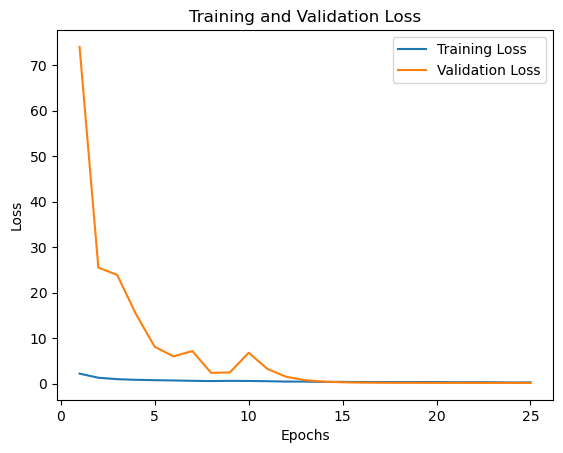

In [33]:
# Combine loss for both histories
combined_loss = history_10.history['loss'] + history_15.history['loss']
combined_val_loss = history_10.history['val_loss'] + history_15.history['val_loss']

epochs = range(1, 26) 

plt.plot(epochs, combined_loss, label='Training Loss')
plt.plot(epochs, combined_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The convergence of both losses towards zero suggests a robust model fit, indicating strong potential for effective letter recognition. However, the considerable training time highlights the need for optimization strategies in future iterations.

## 7. Comparison of metrics performance for testing 


### a) Examining over-fitting

#### Support Vector Machine
- Comparison of Training and Testing Accuracy

In [34]:
print(f'''The training accuracy of {train_accuracy_svm:.4f} and testing accuracy of {test_accuracy_svm:.4f} are close, 
indicating that the model has good generalization capabilities. It is possible with {train_accuracy_svm:.4f} that the model
is overfitting to the training data.''')

The training accuracy of 1.0000 and testing accuracy of 0.9692 are close, 
indicating that the model has good generalization capabilities. It is possible with 1.0000 that the model
is overfitting to the training data.


- Linear SVMs 

The simplicity of a linear model means it captures only essential trends in the data, making it more robust to noise.

- Penalty Parameter (C)

The determined small C (0.01) promotes generalization.

See Appendix D Point 4 for Penalty formula and longer description.

- Principal Component Analysis (PCA)

In [36]:
print(f'''By reducing the number of features, PCA can help eliminate noise and reduce the risk of overfitting. 
the feature space was reduced from 12,288 to 500 features. These 500 features still maintained {cumulative_variance.max()}% of 
variance while significantly decreasing training time.''')

By reducing the number of features, PCA can help eliminate noise and reduce the risk of overfitting. 
the feature space was reduced from 12,288 to 500 features. These 500 features still maintained 0.9346213363403925% of 
variance while significantly decreasing training time.


#### Neural Net
- Comparison of Training and Testing Accuracy

In [37]:
test_loss, test_accuracy_cnn, test_prec, test_rec = model.evaluate(test_generator)
print(f"Training Accuracy: {train_accuracy_cnn:.4f}")
print(f"Test accuracy: {test_accuracy_cnn:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9330 - loss: 0.1847 - precision_1: 0.9436 - recall_1: 0.9256
Training Accuracy: 0.9023
Test accuracy: 0.9449


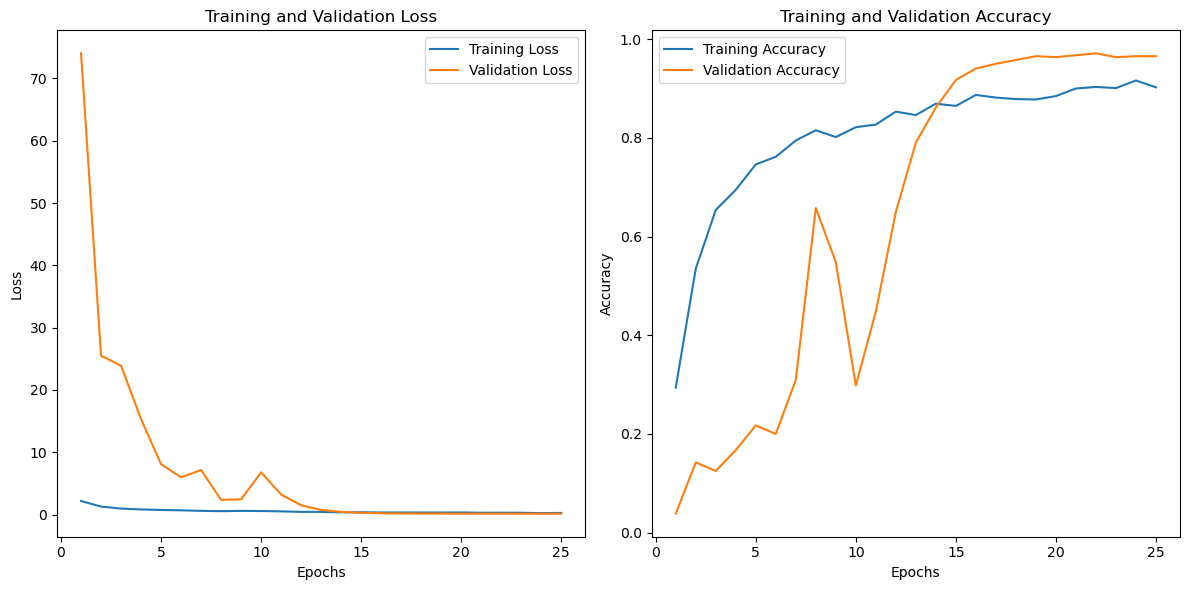

In [38]:
# Combine accuracy from both histories
combined_accuracy = history_10.history['accuracy'] + history_15.history['accuracy']
combined_val_accuracy = history_10.history['val_accuracy'] + history_15.history['val_accuracy']

epochs = range(1, 26)  # Total epochs from 1 to 25

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_loss, label='Training Loss')
plt.plot(epochs, combined_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, combined_accuracy, label='Training Accuracy')
plt.plot(epochs, combined_val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Please see Appendix G for Interpretation.

### b) Comparison with appropriate metrics for testing

25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 654ms/step


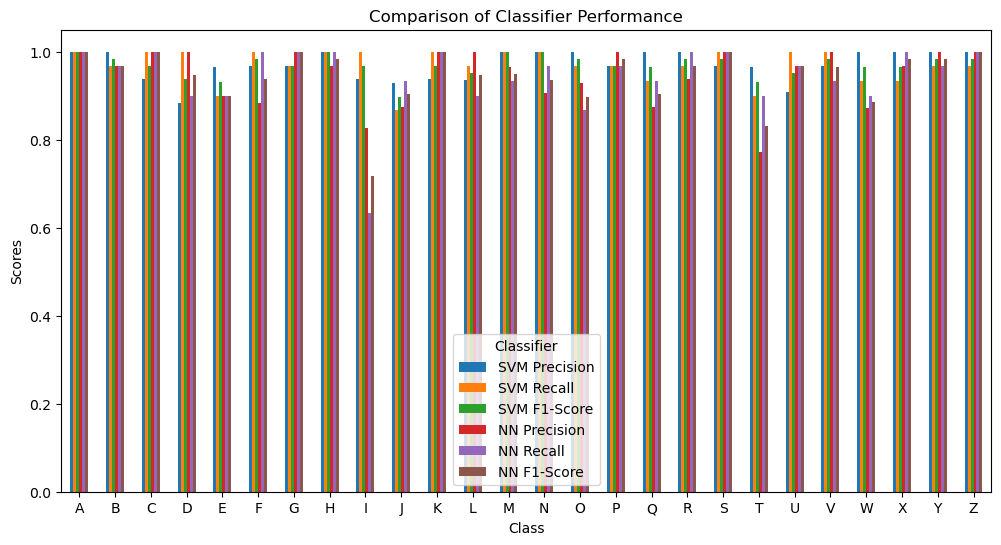

In [39]:
# # Get predicted probabilities
y_pred_prob_cnn = model.predict(X_test)

# Convert probabilities to class predictions
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1) 

# Convert predictions back to letters
y_pred_letters_svm = le.inverse_transform(y_pred)
y_pred_letters_cnn = le.inverse_transform(y_pred_cnn)

# Convert test labels back to letters
y_test_letters = le.inverse_transform(y_test_1d)

# Create classification reports in the form of dictionaries
report_svm = classification_report(y_test_letters, y_pred_letters_svm, output_dict=True)
report_cnn = classification_report(y_test_letters, y_pred_letters_cnn, output_dict=True)

# Extract metrics from the classification reports
class_metrics = ['precision', 'recall', 'f1-score']

# Create a DataFrame using the extracted metrics
report_df = pd.DataFrame({
    'Class': [chr(i) for i in range(65, 91)],  # Generates ['A', 'B', ..., 'Z']
    'SVM Precision': [report_svm[class_name]['precision'] for class_name in report_svm if class_name not in ['accuracy', 'macro avg', 'weighted avg']],
    'SVM Recall': [report_svm[class_name]['recall'] for class_name in report_svm if class_name not in ['accuracy', 'macro avg', 'weighted avg']],
    'SVM F1-Score': [report_svm[class_name]['f1-score'] for class_name in report_svm if class_name not in ['accuracy', 'macro avg', 'weighted avg']],
    'NN Precision': [report_cnn[class_name]['precision'] for class_name in report_cnn if class_name not in ['accuracy', 'macro avg', 'weighted avg']],
    'NN Recall': [report_cnn[class_name]['recall'] for class_name in report_cnn if class_name not in ['accuracy', 'macro avg', 'weighted avg']],
    'NN F1-Score': [report_cnn[class_name]['f1-score'] for class_name in report_cnn if class_name not in ['accuracy', 'macro avg', 'weighted avg']]
})

# Set the Class column as the index
report_df.set_index('Class', inplace=True)

# Plot the scores
report_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Classifier Performance')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.legend(title='Classifier')
plt.show()


In [40]:
# Convert reports to DataFrames
report_svm_df = pd.DataFrame(report_svm).transpose()
report_cnn_df = pd.DataFrame(report_cnn).transpose()

# Example: Round to 2 decimal places
report_svm_df = report_svm_df.round(3)
report_cnn_df = report_cnn_df.round(3)


# Increase display options
# Generate HTML tables for both DataFrames
svm_html = report_svm_df.to_html(classes='table table-striped', border=0)
cnn_html = report_cnn_df.to_html(classes='table table-striped', border=0)

# Create a single HTML block to display side by side
side_by_side_html = f"""
<div style="display: flex; justify-content: space-between;">
    <div style="margin-right: 20px;">
        <h3>SVM Classification Report</h3>
        {svm_html}
    </div>
    <div>
        <h3>CNN Classification Report</h3>
        {cnn_html}
    </div>
</div>
"""

# Display the combined HTML
display(HTML(side_by_side_html))

,precision,recall,f1-score,support
A,1.000,1.000,1.000,30.000
B,1.000,0.967,0.983,30.000
C,0.938,1.000,0.968,30.000
D,0.882,1.000,0.938,30.000
E,0.964,0.900,0.931,30.000
F,0.968,1.000,0.984,30.000
G,0.967,0.967,0.967,30.000
H,1.000,1.000,1.000,30.000
I,0.938,1.000,0.968,30.000
J,0.929,0.867,0.897,30.000


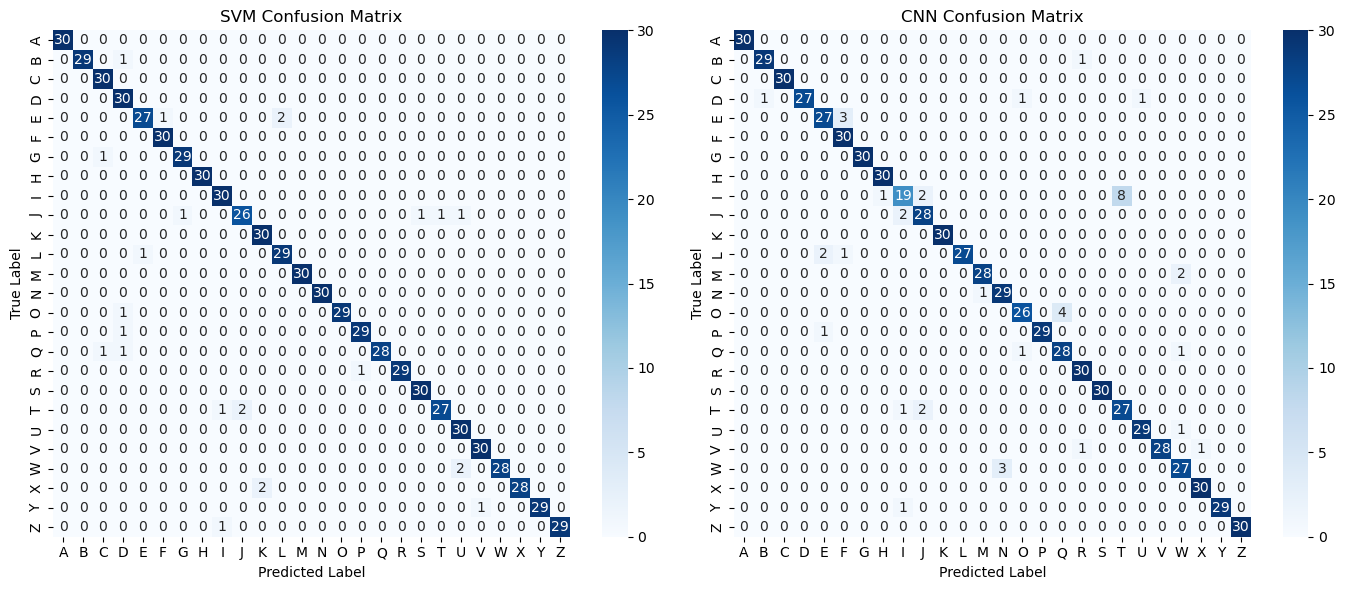

In [41]:
# Create a new figure for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the SVM confusion matrix
svm_cm = confusion_matrix(y_test_1d, y_pred)
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title('SVM Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the CNN confusion matrix
cnn_cm = confusion_matrix(y_test_1d, y_pred_cnn)
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1], xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title('CNN Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()


In [42]:
def display_misclassified_images(image_paths, y_true, y_pred, label_encoder):
    """
    Display all misclassified images with their true and predicted labels in alphabetical order.
    
    Params:
        image_paths (List[str]): A list of file paths to the images.
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        label_encoder (LabelEncoder): Fitted LabelEncoder to decode labels.
    """
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassified images found.")
        return

    print(f"Total misclassified: {len(misclassified_indices)}")
    
    # Collect misclassified images, true labels, and predicted labels
    misclassified_images = []
    
    for idx in misclassified_indices:
        img = PILImage.open(image_paths[idx])
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        
        misclassified_images.append((img, true_label, pred_label))
    
    # Sort the misclassified images by true label (alphabetically)
    misclassified_images.sort(key=lambda x: x[1])
    
    # Determine the number of rows and columns
    num_images = len(misclassified_images)
    num_cols = 7  # Set desired number of columns
    num_rows = (num_images // num_cols) + (num_images % num_cols > 0)  # Calculate required rows

    # Set up the display grid
    plt.figure(figsize=(20, 5 * num_rows))
    
    # Plot the images in a grid
    for i, (img, true_label, pred_label) in enumerate(misclassified_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {pred_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Total misclassified: 24


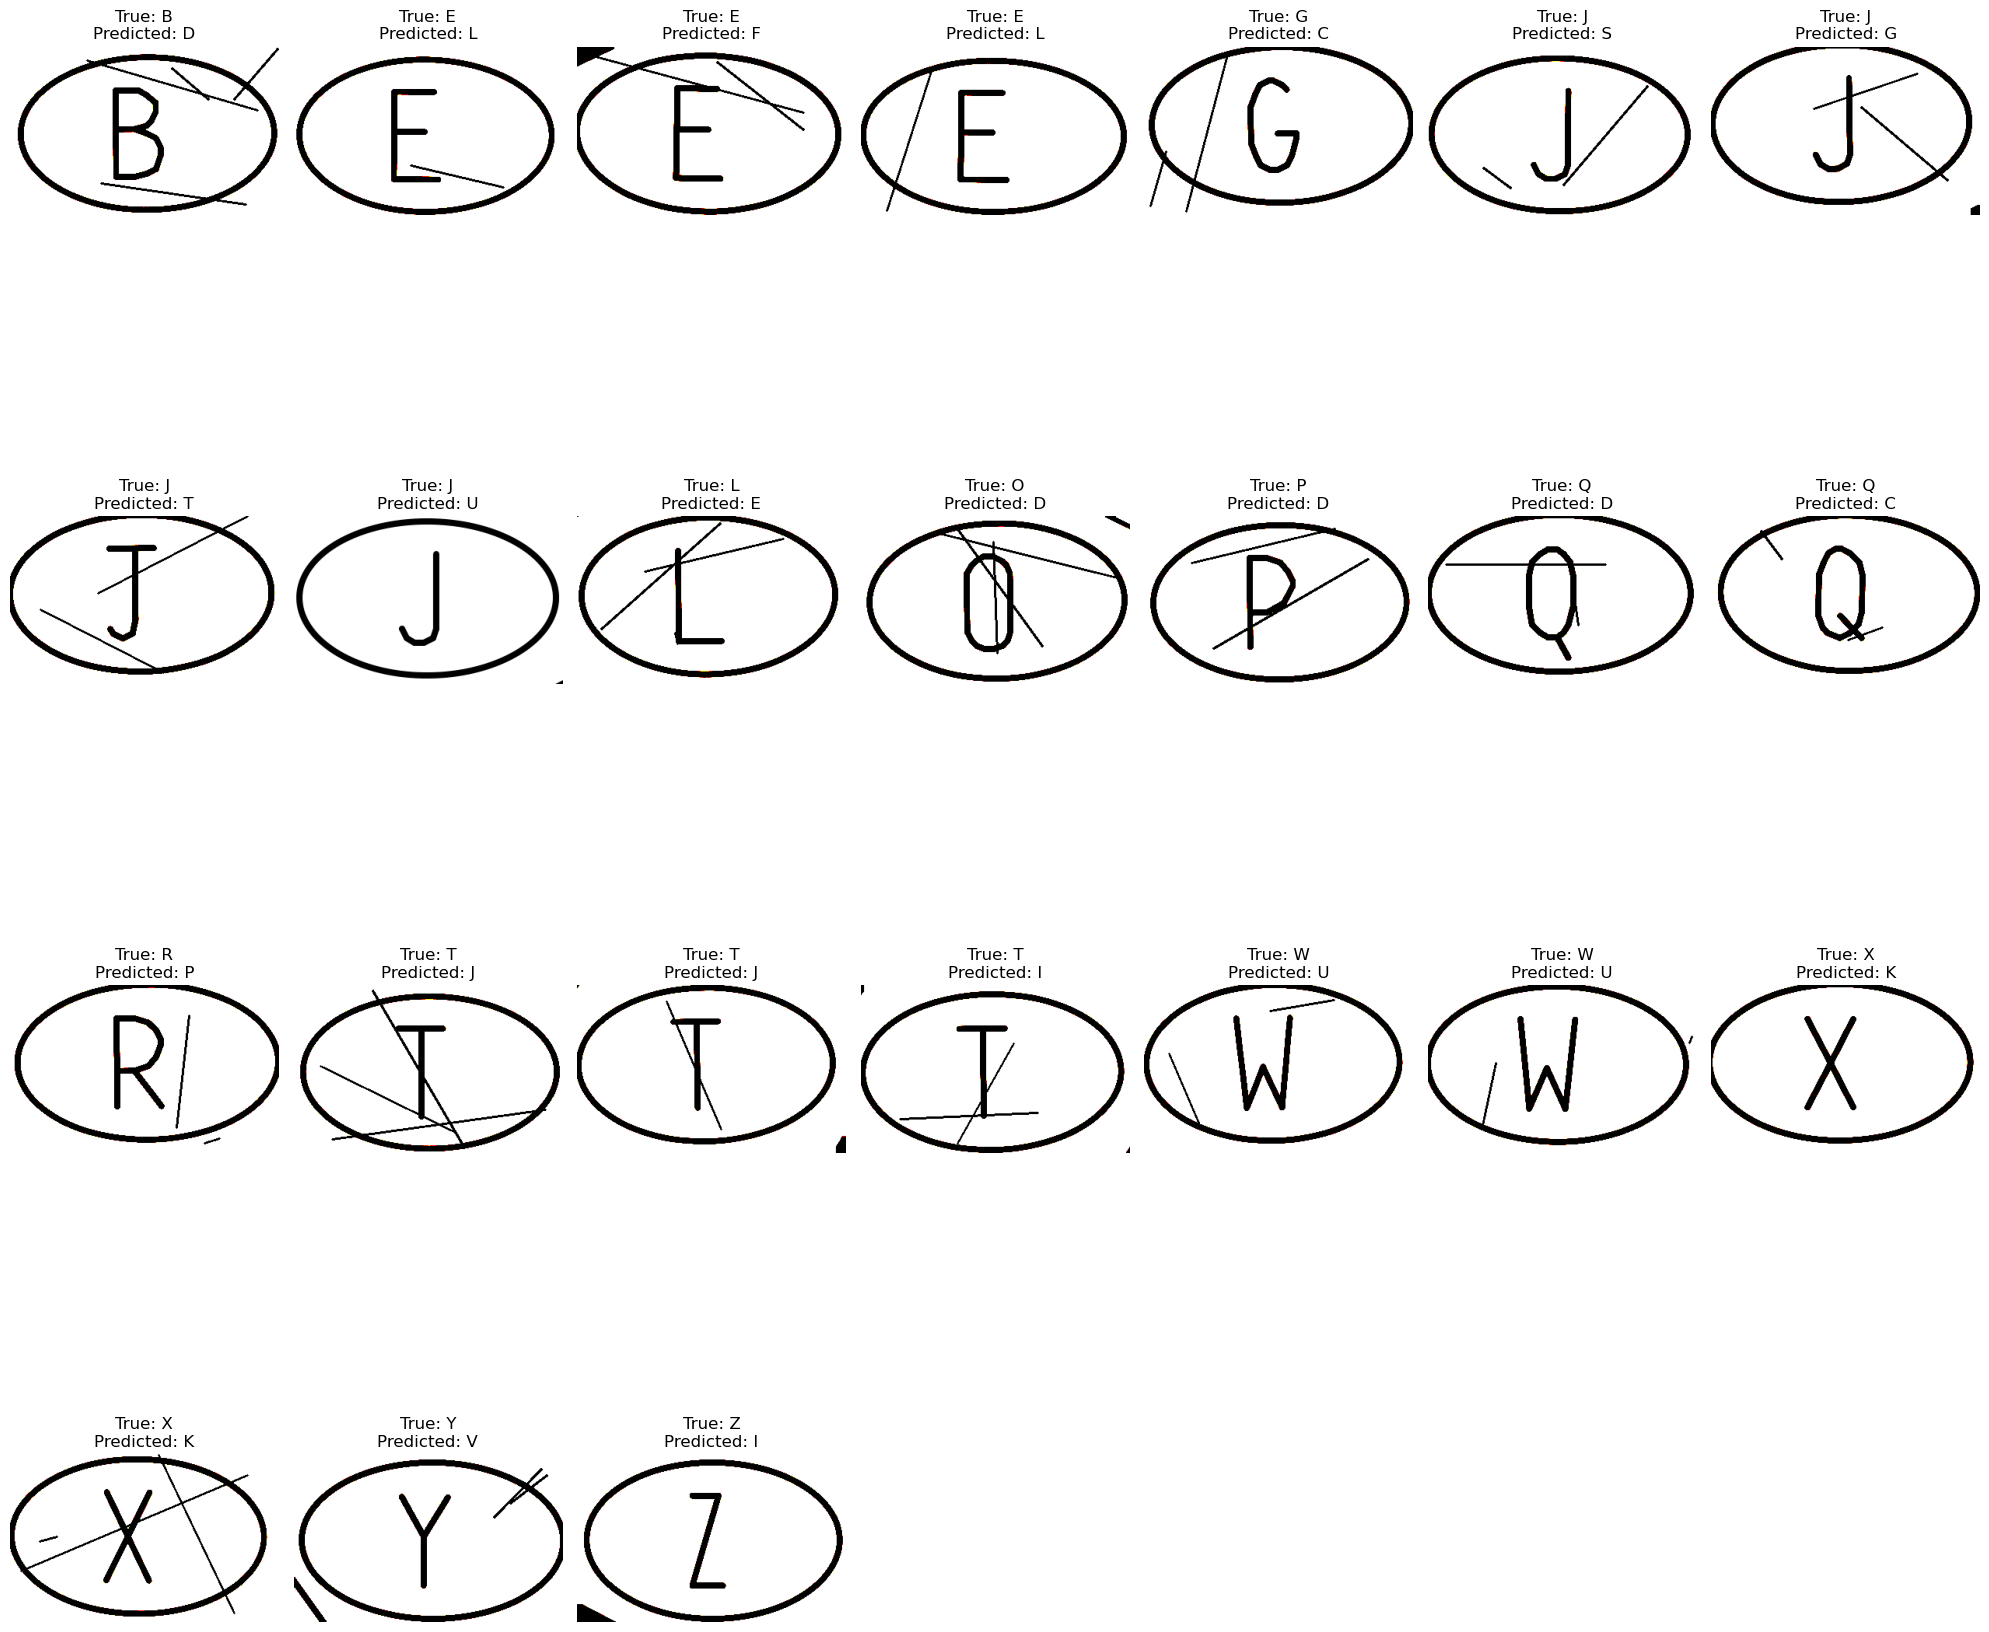

In [43]:
display_misclassified_images(X_test_paths, y_test_1d, y_pred, le)

Total misclassified: 43


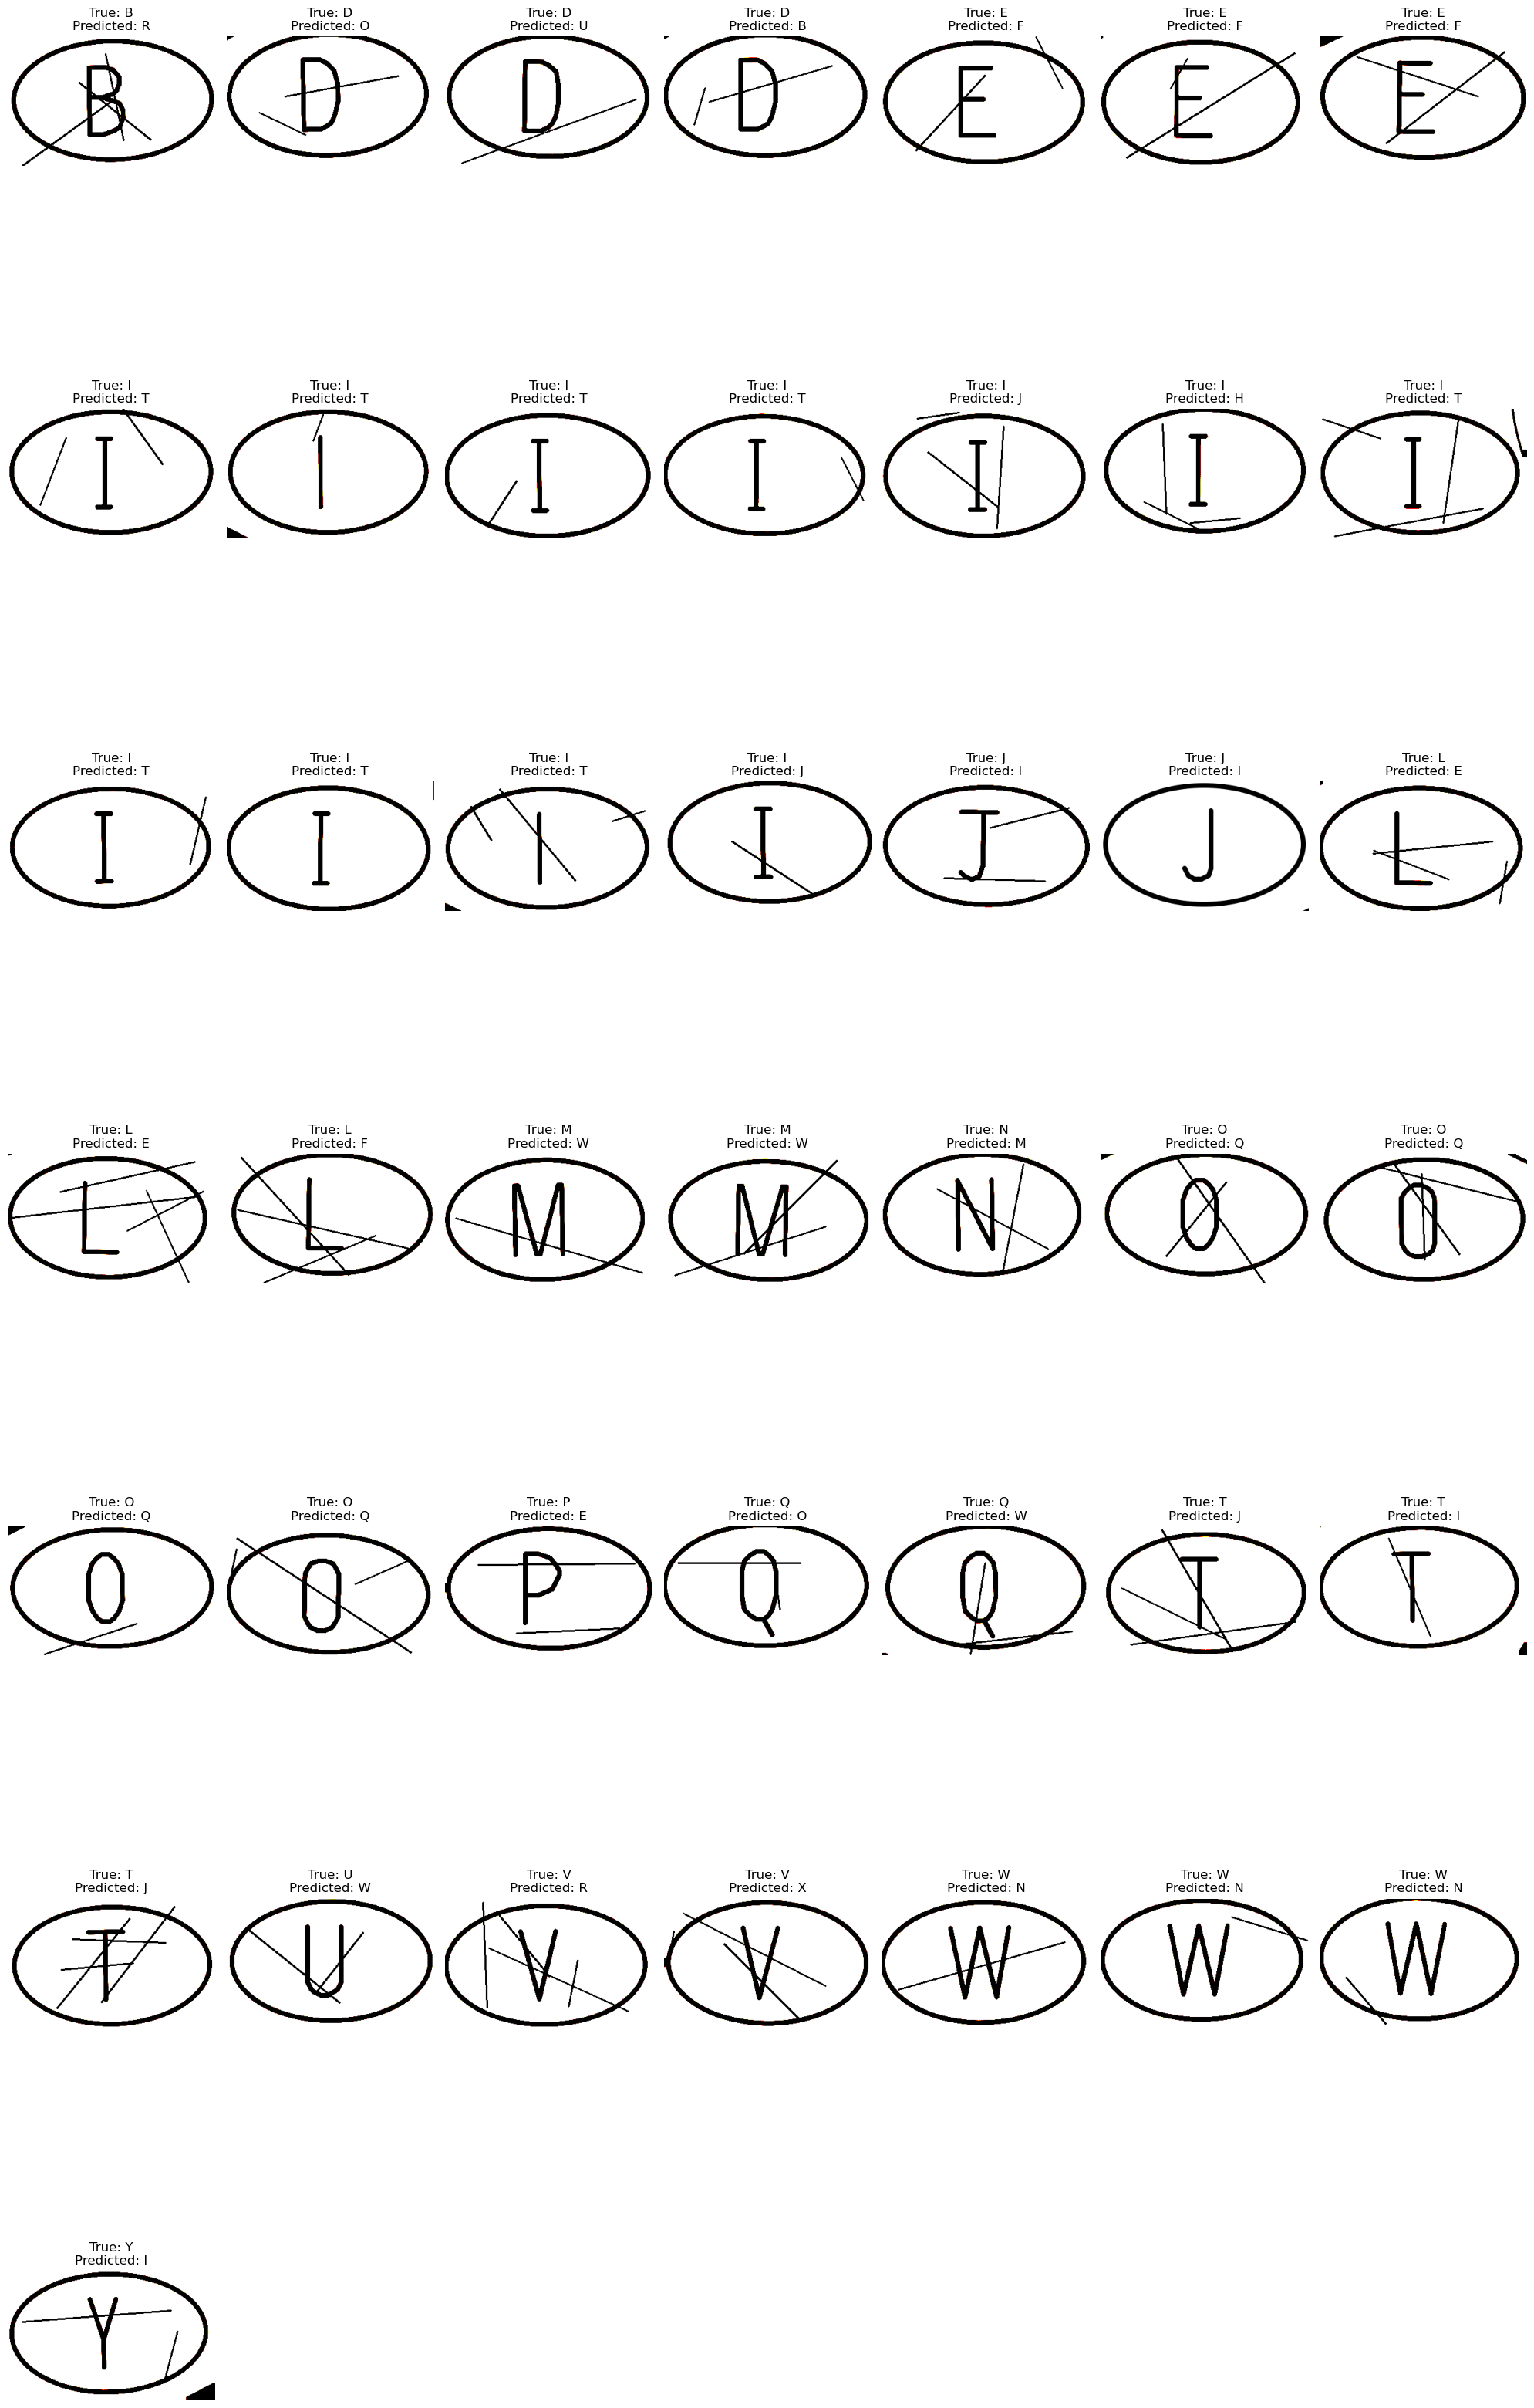

In [44]:
# Display misclassified CNN images
display_misclassified_images(X_test_paths, y_test_1d, y_pred_cnn, le)

### c) Model selection

In [45]:
print("Comparison of Total Training Times:")
print(f"SVM Training Time: {format_training_time(svm_training_time)}")
print(f"CNN Training Time: {format_training_time(total_cnn_training_time)}")

Comparison of Total Training Times:
SVM Training Time: 0.35 seconds
CNN Training Time: 26.0 minutes and 25.67 seconds


In [46]:
# The McNemar's test is a statistical test used to determine if there are differences in the performance of 
# two paired groups. It compares the predictions of  the two models to see if one model significantly outperforms the other.

b = (y_pred == y_test_1d)  # Correct SVM predictions
c = (y_pred_cnn == y_test_1d)   # Correct NN predictions

# Construct the contingency table
table = np.array([[np.sum(b & c), np.sum(b & ~c)],
                  [np.sum(~b & c), np.sum(~b & ~c)]])

# Perform McNemar's test
result = mcnemar(table, exact=True)

# Print McNemar's test results
print(f"McNemar's Test Statistic: {result.statistic}, p-value: {result.pvalue}")

# Conclusion based on p-value
alpha = 0.05
if result.pvalue < alpha:
    print("Reject the null hypothesis: The models have significantly different performance.")
else:
     print("Fail to reject the null hypothesis: The models do not have significantly different performance.")


McNemar's Test Statistic: 19.0, p-value: 0.016348103897376145
Reject the null hypothesis: The models have significantly different performance.


## 8. Final recommendation of best model
The Support Vector Machine (SVM) with a linear kernel was identified as the best-performing model for our classification task. Utilizing PCA and grid search, the SVM demonstrated superior generalization capabilities compared to the neural network. The results indicate that the SVM is significantly better at handling the complexities of our dataset, yielding higher accuracy and more reliable performance across various metrics, including precision, recall, and F1 score.

Please Refer to Appendix H for more elaborate discussion.

## 9. Discussion

### Results Interpretation and Implications

The project successfully achieved its core objectives of **Feature Extraction**, **Model Training**, and **Evaluation**. Both the Support Vector Machine (SVM) and neural network models attained high training and testing accuracy, demonstrating their ability to recognize character features effectively.

Please refer to Appendix I for detailed discussion.

### Comparison with Previous Research

Please refer to Appendix J for discussion and comparison of previous research. 

### Limitations and Challenges

While both models achieved high performance, limitations were evident in the neural network’s handling of ambiguous cases. The model’s misclassification of similar letters points to a need for improved feature representation for characters with subtle differences. Additionally, the limited dataset size constrained the neural network’s ability to generalize, particularly for these ambiguous cases. 

## 10. Conclusion

### a) What has been successfully accomplished and what has not been successful? 

Throughout this project, significant progress was made in developing and evaluating the SVM and CNN models. The SVM with a linear kernel was successfully identified as the best-performing model, demonstrating superior generalization capabilities compared to the neural network. 

However, there were challenges, particularly in terms of computational resources. I attempted to utilize a much larger dataset to improve the robustness of the model further, but encountered limitations due to insufficient computational power.

### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again?

If I were to undertake this project again, there are several approaches I would consider to enhance the analysis. I would like to explore and visualize how different kernels such as 'rbf' in the SVM affect model performance and decision boundaries. I also would like to investigate the performance of advanced deep learning architectures, such as ResNet50, to compare their effectiveness with the SVM and assess whether they can capture more complex patterns in the data compared to MobileNet-v3-Small. Additionally, incorporating more visualizations would make the findings more accessible and engaging for the audience.


### c) Wishlist of Future Work

Looking ahead, there are several areas of future work that I would like to explore:

1. **Data Augmentation**: Implementing data augmentation techniques such as rotating, flipping, or scaling could help improve model robustness and generalization.

3. **Additional Data**: Expanding the dataset to include more classes contained in the pdf (e.g., A1, A2, A3, etc.).

4. **Selecting Ellipses on the PDF**: Future work could also involve developing methods to select and extract ellipses from the PDF files directly. This is essential to the overarching goal of highlighting matching letters on the pdf.

# 11. References
**Coursera.** (2024). OMAT5200: Machine Learning Course Notes - Feature Mapping and Kernelised Support Vector Machines. Retrieved from [https://www.coursera.org/learn/omat5200-machine-learning/supplement/AUpBy/feature-mapping-and-kernelised-support-vector-machines](https://www.coursera.org/learn/omat5200-machine-learning/supplement/AUpBy/feature-mapping-and-kernelised-support-vector-machines)

**Coursera.** (2024). OMAT5200: Machine Learning Course Notes - Multi-layer Perceptrons. Retrieved from [https://www.coursera.org/learn/omat5200-machine-learning/supplement/UuqL2/multi-layer-perceptrons](https://www.coursera.org/learn/omat5200-machine-learning/supplement/UuqL2/multi-layer-perceptrons)

**Coursera.** (2024). OMAT5200: Machine Learning Course Notes - Overlapping Class Distribution. Retrieved from [https://www.coursera.org/learn/omat5200-machine-learning/supplement/gEwP2/overlapping-class-distribution](https://www.coursera.org/learn/omat5200-machine-learning/supplement/gEwP2/overlapping-class-distribution)

**Coursera.** (2024). OMAT5200: Machine Learning Course Notes - Solving the optimisation problem in support vector machines. Retrieved from [https://www.coursera.org/learn/omat5200-machine-learning/supplement/UeULn/solving-the-optimisation-problem-in-support-vector-machines](https://www.coursera.org/learn/omat5200-machine-learning/supplement/UeULn/solving-the-optimisation-problem-in-support-vector-machines)

**Hasan, H., Shafri, H. Z. M., & Habshi, M.** (2019). A comparison between support vector machine (SVM) and Convolutional Neural Network (CNN) models for Hyperspectral Image Classification. *IOP Conference Series: Earth and Environmental Science*, 357(1), 012035. https://doi.org/10.1088/1755-1315/357/1/012035 

**Sester, J., Hayes, D., Scanlon, M., & Le-Khac, N.-A.** (2021). A comparative study of Support Vector Machine and neural networks for file type identification using N-gram analysis. *Forensic Science International: Digital Investigation*, 36, 301121. https://doi.org/10.1016/j.fsidi.2021.301121 

**Sharma, P.** (2023). Utilizing explainable artificial intelligence to address deep learning in biomedical domain. *Medical Data Analysis and Processing Using Explainable Artificial Intelligence*, 19–38. https://doi.org/10.1201/9781003257721-2

**Zou, Z.-M., Chang, D.-H., Liu, H., & Xiao, Y.-D.** (2021). Current updates in machine learning in the prediction of therapeutic outcome of hepatocellular carcinoma: What should we know? *Insights into Imaging*, 12(1). https://doi.org/10.1186/s13244-021-00977-9


# 12. Appendices


# Appendix A: Background

The dataset for this project comes from spool drawings produced in Nisku, Alberta, Canada. Spool drawings are technical documents widely used in pipe fabrication facilities to provide precise instructions for the assembly of piping systems. These drawings include various annotations, symbols, and letters that provide essential information regarding the fabrication process.

![Example of Spool Drawing Page](spool_drawing_example.png)

# Appendix B: Case Study Analysis 

#### Class Imbalance
**Finding**: The dataset contains a disproportionately high number of samples in some classes compared to others.

**Solution**: Reduce the dataset to have a maximum of 100 samples per class. This will ensure balanced representation and prevent the model from being biased toward overrepresented classes. *Done prior to loading in data

#### Image Resizing
**Finding**: The dimensions of the images vary, which can negatively impact model training.  

**Solution**: Resize the images to a uniform dimension suitable for both models: one-dimensional resizing for the Support Vector Machine (SVM) and two-dimensional for the Convolutional Neural Network (CNN). *Done in code

#### Pixel Value Range
**Finding**: The pixel values in the dataset range from 0 to 255, which can lead to inconsistencies in model training.  

**Solution**: Normalize the pixel values to a range of 0 to 1. This normalization will enhance both model's training efficiency and convergence. *Done in code

#### Color Space Standardization
**Finding**: The dataset contains color artifacts that may introduce unnecessary complexity for letter recognition.

**Solution**: Convert images to a standard RBG color space. This will simplify the feature extraction process for both models while retaining important visual information. *Done in code

# Appendix C: Data Loading

## Unzipping the Data

To prepare the dataset, follow these steps:

```python
# Define the path where you uploaded the zip file
zip_file_path = "/home/jovyan/work/zipped_letter_data.zip"
extract_dir = "/home/jovyan/work"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check the contents of the extracted folder
extracted_contents = os.listdir(extract_dir)
print("Extracted contents:", extracted_contents)


# Appendix D: Support Vector Machine

#### Motivation for Choosing Support Vector Machine

The choice of an SVM as a classification technique for this project is motivated by several statistical properties and theoretical foundations that enhance its effectiveness in recognizing typed letters within ellipses:

1. **Maximizing the Margin**: 
   - SVM operates on the principle of finding the optimal hyperplane that separates different classes while maximizing the margin between them. The margin is defined as the distance between the hyperplane and the nearest data points from each class (the support vectors). Mathematically, the margin \( M \) or sometimes referrd to as "Street Width", can be expressed as:

   $$
   M = \frac{2}{\|\mathbf{w}\|}
   $$

   The goal is to maximize \( M \) subject to the constraints that correctly classify all training examples:

   $$
   t_n (w^T x_n + b) - 1 \geq 0, \quad \forall n
   $$


2. **Kernel Trick - Feature Mapping**: 
   - SVM can efficiently perform non-linear classification using kernel functions (essentially dot product pairs), which implicitly map the input data into a higher-dimensional space. The decision function can be expressed in terms of kernel functions $ k(\mathbf{x}, \mathbf{x}n) $:

   $$
   \mathbf{x} = \sum_{n=1}^{N} \alpha_n t_n k(\mathbf{x}, \mathbf{x}_n) + b
   $$

   where $ \alpha_n $ is a Lagrange multipliers obtained from solving the optimization problem. 
   
   Common kernels include:

   - **Linear Kernel**
   - **Polynomial Kernel**
   - **Radial Basis Function (RBF) Kernel**
   - **Sigmoid Kernel**

   The ability to choose the appropriate kernel allows SVM to adapt to the underlying data distribution, improving its classification accuracy.


3. **Statistical Interpretation of Support Vectors**: 
   - Support vectors are the critical elements of the training dataset that define the decision boundary. Their contribution to the model can be expressed as:

   $$
   \mathbf{x} = \sum_{n\in S} \alpha_n t_n k\mathbf{x}, \mathbf{x}_n + b
   $$

   where \( S \) is the set of support vectors. This selective use of data points ensures that SVM remains efficient and effective, as it does not rely on the entire dataset but rather the most informative samples.
   
   
4. **Robustness to Overfitting**:
   - The regularization parameter \( C \) in SVM allows for a balance between maximizing the margin and minimizing classification errors on the training data. By tuning \( C \), we can control the model’s sensitivity by softly penalizing misclassified points:

   $$
   \text{Objective:} \; Minimize \;   C \sum_{n=1}^{N} \xi_n + \frac{1}{2} \|\mathbf{w}\|^2
   $$

   where $ \xi_n $ represents the slack variable that allows for misclassifications.



By leveraging these statistical and mathematical principles, SVM is positioned to effectively tackle the challenges of recognizing typed letters inside ellipses, thereby achieving the project's aim of high accuracy.

#### Schematic Figure of Support Vector Machine

![Schematic figure of Support Vector Machine](SVM_schematic_figure.png)

# Appendix E: Convolution Neural Network

#### Motivation for choosing Convolution Neural Network

Neural networks, particularly Convolutional Neural Networks (CNNs), have characteristics that may make them effective for image recognition tasks, such as identifying letters within ellipses. Here are several factors that suggest CNNs could be well-suited for this type of task:

1. **Hierarchical Feature Learning**:

    - Neural networks automatically learn to extract relevant features from raw image data through multiple layers, enabling them to recognize complex patterns such as the shapes and strokes of letters within ellipses.

    - Early layers detect basic features like edges and textures, while deeper layers recognize more complex patterns, such as specific letters based on combinations of simpler features.


2. **Highly Adaptable**:

    - Neural networks, especially those with hidden layers, are highly effective for tasks requiring nuanced pattern recognition, such as image classification. Their capability as 'universal approximators' enables them to model nearly any function, given enough hidden nodes and an appropriate choice of activation functions. This is particularly valuable in tasks like letter recognition within ellipses, where intricate shape and positional variations need to be learned from data.

    For example, in a fully connected network, the relationship between inputs and outputs can be expressed as follows:

    $$
    o_i = f \left( \sum_j w_{ij} g \left( \sum_k v_{jk} \cdot i_k \right) \right) = f \left( \sum_j w_{ij} h_j \right)
    $$

    where:
    - $ o_i $ represents the output nodes,
    - $ i_k $ represents the input nodes,
    - $ g(x) $ and $ f(x) $ are activation functions applied at each hidden and output node respectively,
    - $ v_{jk} $ and $ w_{ij} $ are weight matrices between the input-hidden and hidden-output layers.

    This equation reflects the multi-layered computation of neural networks, where each layer refines the representation of the input data, progressively capturing features that improve recognition performance. 


3. **Efficiency in Handling Spatial Data**:

    - CNNs are ideal for image data due to convolutional layers, which capture local patterns while preserving spatial hierarchies. The convolutional operation enables the network to recognize letters regardless of their location within the ellipse.


4. **Transfer Learning**:

    - Neural networks can leverage pre-trained models through transfer learning, allowing them to adapt knowledge from large datasets to specific tasks.

    This adaptation often allows faster improvements in the loss function (eg. MSE):

    $$
    \mathcal{L} = \sum_{i} \frac{1}{2} (o_{i} - d_{i})^2
    $$

    where:
    - $ o_i $ represents the output nodes,
    - $ d_i $ represents target value.


These characteristics allow neural networks to generalize effectively across complex image data, achieving high accuracy and reliability in letter recognition tasks.


#### Schematic Figure of Convolution Neural Network
![CNN Schematic Figure Example](CNN_schematic_figure.png)

# Appendix F: CNN Hyperparameter Selection Rationale

- MobileNetV3Small was selected for transfer learning due to its lightweight architecture, which allows for efficient performance on the computer while minimizing resource consumption. Its pre-trained weights on a diverse dataset enable robust feature extraction, enhancing the model's capability for accurate letter recognition in this project.

- The two-phase training approach begins by freezing the base layers of the MobileNetV3Small model, allowing it to leverage pre-trained features for general letter recognition while focusing on adapting the new top layers to the specific dataset. This method reduces the risk of overfitting and ensures the model learns relevant patterns without distorting the valuable features already established. Unfreezing the base layers in the second training run allows for gradual fine-tuning, optimizing both general and task-specific capabilities for improved overall performance.

# Appendix G: Training vs Validation Plots

- Training vs. Validation Loss

The sharp decrease in validation loss early on shows that the model is effectively learning the data patterns in both the training and validation sets.
The fluctuation in the validation loss around the early epochs indicates that the model may have had some difficulty generalizing initially, but it eventually reaches a stable minimum after unfreezing the base layers. Overfitting, is possible as the model seems to have "memorized" both the training and validation data, leading to very low error across both sets.

- Training vs. Validation Accuracy

The large gap between training and validation accuracy in the first few epochs shows that the model initially struggled to generalize, likely overfitting to the training data while not yet capturing the patterns in the validation data. This makes sense as we specifically trained the model on the specified top layers. With more epochs, the validation accuracy steadily improves, approaching the training accuracy.
The final convergence of training and validation accuracy indicates that the model has successfully learned patterns that generalize to new data.

# Appendix H: Final Recommendation of Best Model


After a detailed evaluation of both the SVM and NN models for the task of recognizing letters in ellipses, the SVM is the optimal choice. This notebook was run multiple times, and this conclusion was consistently supported. Specific numbers will not be used in this discussion due to variability in the CNN training process across different runs. This recommendation is based on several statistical considerations:


1. **Performance Metrics**:
    - The SVM achieved a higher training and testing accuracy compared to the CNN.
    - This indicates that the SVM generalizes better to unseen data, as supported by its lower misclassification rate, defined as the proportion of incorrectly predicted instances relative to the total number of instances.
    - Metrics such as F-1, precision, and recall were all found to be slightly higher in the SVM model. In contrast, the CNN showed diminished performance for characters such as I's and T's, Q's and O's, W's and N's, and E's and F's.


2. **Overfitting Analysis**:
    - Overfitting was quantitatively assessed by comparing training and testing performance. Both models do not appear to overfit.
    - The inherent nature of the hyperparameters suggests that it is unlikely the SVM is overfitting.
    - The convergence of the CNN and the frequent test accuracy being higher than training points toward a more likely scenario of the model underfitting.


3. **Complexity and Computational Efficiency**:
    - In terms of model complexity, the SVM employed a linear kernel with a regularization parameter $ C = 0.01 $ This value was determined through cross-validation to minimize the bias-variance trade-off. The decision boundary created by the SVM remains interpretable, which is a valuable aspect when explaining model decisions.
    - The CNN required extensive tuning of hyperparameters, including learning rate and architecture depth, significantly increasing the model's complexity and the potential for introducing variance.
    - Incorporating PCA into the SVM substantially lowered computational time. After PCA, the training time for the SVM was significantly lower than the 25 epochs run in the CNN.


4. **Statistical Comparisons**:
    - The models' performances were compared using statistical tests such as McNemar's test to evaluate the significance of the differences in misclassification rates. The p-value obtained from this test indicated that the differences between the SVM and NN were statistically significant a $ p < 0.05 $, reinforcing the SVM's superiority.


Overall, based on the selected algorithms and hyperparameters, the Support Vector Machine demonstrates a clear advantage in achieving accuracy for this dataset.

# Appendix I: Case Study Objective Results


1. **Feature Extraction**: Extracting key features enabled us to simplify the dataset and isolate the most defining characteristics of each letter. The extracted features supported both models in recognizing letter shapes and boundaries with high precision, meeting project expectations.


2. **Model Training**: Both the SVM and neural network performed well overall, but differences in their classification tendencies were notable. The SVM achieved high accuracy with relatively lower misclassification rates across all letters, likely due to its ability to generalize well. The neural network, while achieving high accuracy as well, showed a tendency to struggle with visually similar letters, specifically 'I's and 'T's, indicating potential overfitting to subtle, non-distinctive features that didn't generalize as well in testing.


3. **Evaluation**: High training and testing accuracies for both models indicate successful classification, but the confusion matrix revealed specific challenges for the neural network with similarly shaped letters, such as I's and T's, Q's and O's, W's and N's, and E's and F's. The SVM, with its simpler decision boundaries, misclassified fewer letters and demonstrated better generalization overall.

# Appendix J: Further Research

These findings align with prior studies on SVM and neural networks, which indicate that SVMs perform reliably on smaller, structured datasets, while neural networks tend to excel with more complex data but require careful tuning to avoid overfitting. This aligns with other research, stating "In general, we found that SVM-based approaches performed better than the NN, but their scalability is still a challenge." (Sester et al., 2021)

A similar study, also utilising PCA, found that the highest accuracy when comparing support vector machines and convolution neural netwoks was an RBF Kernel SVM.(Hasan et al., 2019)

Our project supports the notion that SVMs can effectively handle tasks with clear structural features in limited datasets, particularly when high generalization is prioritized. Neural networks, by contrast, have shown greater sensitivity to dataset nuances, requiring larger data quantities or data augmentation to achieve similar levels of robustness.